In [39]:
import matplotlib
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import curve_fit
from scipy import signal
from numpy.fft import fft, fftfreq
import math
import matplotlib.pyplot as mpl
from matplotlib.ticker import MultipleLocator

matplotlib.use('nbAgg')
#matplotlib.rcsetup.interactive_bk

import matplotlib
#matplotlib.get_backend()

In [40]:
kb = 8.62e-5 #boltzmann constant, eV/K
#hbar = 6.58e-16 #reduced Plank constant, in eV.s
hbar = 1.0545718e-34 #m2 kg / s
e = 1.60e-19 #electron charge in C
m = 9.11e-31 #electron mass in kg
RK = 1/(e/hbar/(2*np.pi)) #von Kiltzing constant = e^2/h

mpl.rcParams['axes.linewidth'] = 1.0 #set the value globally

def deriv (y, x, yaxis=0, xaxis=0): #finite central difference derivative -- first order; y is of type ndarray 
    diff = np.roll (y,1,axis=yaxis) - np.roll (y,-1,axis=yaxis)
    dx = np.roll (x,1,axis=xaxis)  - np.roll (x,-1,axis=xaxis)
    return diff/(dx)

In [41]:
fpath = '2018-05-09_13-24-18.csv'
#fpath = '2018-05-09_16-05-06.csv'

In [42]:
fpathbase = '/Users/Annelise/desktop/Spanish_Acquisition/ABG414HB2C2/'
fpathsplit = (fpathbase , fpath)
fpathcat = fpathbase + fpath

rdata = np.loadtxt (fpathcat,skiprows=1, dtype=float, delimiter=',')
pfdata = pd.read_csv(fpathcat)

pfdata.head()

,Time (s),Dummy,temp (K),Field (kG),Voltage (V),phase
0,0.000000,0.0,1.456,-5.0,0.003843,-2.61
1,0.410361,0.0,1.456,-5.0,0.003843,-2.61
2,0.776122,0.0,1.456,-5.0,0.003843,-2.61
3,1.278135,0.0,1.456,-5.0,0.003842,-2.61
4,1.675765,0.0,1.456,-5.0,0.003842,-2.61


In [43]:
#num_loops = 2 #number of nested loops
#loop_indices = [1,2] #indices of columns of the looping elements. 

num_loops = 1 #number of nested loops -- i.e. the number of parameters that are being swept in the experiment.
loop_indices = [4] #indices of columns of the looping elements. 

# the next lines insure that the raw data is 'square', i.e. not missing a line or data point

#basic_shape = [len(np.unique(rdata[:,c])) for c in loop_indices] # use this if you don't have duplicate data
basic_shape = [len((rdata[:,c])) for c in loop_indices] # use CAUTIOUSLY if you do have duplicate data

unique_length = 1
for x in basic_shape:
    unique_length = unique_length*x

rshape = rdata.shape
num_rows = rshape [0]
num_cols = rshape [1]
if unique_length != num_rows:
    raise ValueError('Shape mismatch: Number of rows in raw data is %d, '%num_rows \
                     +'but looping over elements in columns  %s '%str(loop_indices) \
                     +'generates %d many unique elements'%unique_length) 

# format the data into a tensor with many 'dimensions' each of which represents one looping element
tensor_shape = list(basic_shape)
tensor_shape.append (num_cols)
data_fmt = rdata.reshape (tensor_shape)

In [44]:
# TODO: autogenerate this code -- it's messy.
# What are the indices of the quantities of interest
b_index = 3
#g_index = 0
v_index = 4
#i_index = 5
vbias_index = 1

# What are the conversion factors for the quantities of interest.
# Format them such that x * x_conv gives a quantity in SI units.

b_conv = 1.0 / 10 # kG to T
#g_conv = 2
v_conv = 1e6 # gain etc of the equipment, to V
#i_conv = 1 # gain etc of the equipment, to A
#vbias_conv = 22.0/272000

In [45]:
b_field = data_fmt[...,b_index]*b_conv
#gate = data_fmt[...,g_index]*g_conv
#current = data_fmt[...,i_index]*i_conv
voltage = data_fmt[...,v_index]*v_conv
#vbias = data_fmt[...,vbias_index]*vbias_conv

# In a DC experiment, differentiate voltage w/r/t current to get resistance.
#v_bias_axis = num_loops - 1 # the axis, in the 
# variables 'current' and 'voltage', along which v_bias is being swept
#res = deriv (voltage, current, yaxis=v_bias_axis, xaxis=v_bias_axis) #resistance
#cond = 1/res
current = 100e-3

# In a lock-in experiment, calculate resistance and conductance.
cond = current/voltage
res = voltage/current 

# for hall-bar experiments, what is the lenght to width ratio
L2Wratio = 8

cond_norm = cond * RK 
res_norm = res / RK 

#for hall-bar experiment, calculate resistivity and conductivity

resistivity = res / L2Wratio
conductivity = cond * L2Wratio

# collect all the quantities we just calculated in a tensor called proc_data
proc_data = np.array([voltage, cond_norm, res_norm, resistivity, conductivity])
proc_data_shape = proc_data.shape

# create a new tensor called data that contains the raw data, the pre-formatted data, and the proc_data
num_new_cols = proc_data_shape[0]
full_shape = list(tensor_shape)
full_shape [-1] = full_shape[-1] + num_new_cols
data=np.zeros(full_shape)
data[...,0:num_cols] = data_fmt

for c in range(num_new_cols):
    data[...,num_cols+c]=proc_data[c]

# Fitting to data start here 

## Defintions

In [46]:
h = hbar/(2*np.pi)
alpha = 1e-11 #eVm
carrierdensity = 8.9e15 #/m^2
m_eff = 0.014*m #kg
tao_tr = 1e-9
tao_phi = 1e-6
C = 2.71828 #Euler constant
N=50

k_F = np.sqrt(2*np.pi*carrierdensity)
v_F = hbar*k_F/m_eff
delta = 2*alpha*k_F
D = hbar*v_F/delta
#tao_s = 2*hbar**2/((delta**2)*tao_tr)
#H_phi = hbar/(4*e*D*B*tao_phi)
#H_tr = hbar/(4*e*D*B*tao_tr)
#H_s = hbar/(4*e*D*B*tao_s)

In [47]:
#Define fucntions to be fit to data

def a_n(N, B, H_phi, H_s):
    #H_phi = hbar/(4.0*e*D*B*tao_phi)
   # H_s = hbar/(4.0*e*D*B*tao_s)
    return N + 1.0/2 + H_phi/B + H_s/B

def sumOfSeries1(N, B, H_phi):
    #H_phi = hbar/(4.0*e*D*B*tao_phi)
    z = H_phi/B - 1.0/2
    sum1 = 0
    for i in range(1, N+1):
        sum1 +=z/(i*(i + z))   
    return sum1
 
def sumOfSeries2(N, B, H_phi, H_s):
   # H_phi = hbar/(4*e*D*B*tao_phi)
   # H_s = hbar/(4*e*D*B*tao_s)
    sum2 = 0
    for i in range(1, N+1):
        temp = (3/i  - (3*a_n(i,  B, H_phi, H_s)**2 + 2*a_n(i, B, H_phi, H_s)*(H_s/B) - 1 - 2*(2*i + 1)*(H_s/B))/((a_n(i, B, H_phi, H_s) + (H_s/B))*a_n(i-1, B, H_phi, H_s)*a_n(i+1, B, H_phi, H_s)
                            - 2*(H_s/B)*((2*i +1)*a_n(i, B, H_phi, H_s)-1)))   
        #print (temp)
        sum2 += temp
    return sum2

#def Psi(B, tao_phi):
   # C = 2.71828
   # H_phi = hbar/(4*e*D*B*tao_phi)
   # z = H_phi - 1/2
   # arg = 1 + z
   # return sumOfSeries1(N, B, tao_phi) - C

# Function to be fit to data

def func(B, H_phi, H_s):
    #H_tr = hbar/(4*e*D*B*tao_tr)
    H_tr = 1 #H_tr<<1 for func to be valid
    #H_phi = hbar/(4.0*e*D*B*tao_phi)
   # H_s = hbar/(4.0*e*D*B*tao_s)
    
    #return [(1/a_n(0, B, H_phi, H_s)), (2*a_n(0, B, H_phi, H_s) + 1 + (H_s/B))/(a_n(1, B, H_phi, H_s)*(a_n(0, B, H_phi, H_s) + (H_s/B)) - 2*(H_s/B)),
                          #sumOfSeries2(N, B, H_phi, H_s), (sumOfSeries1(N, B, H_phi) - C) + 3*C]

    return (-e**2/(4*hbar*np.pi**2))*(1/a_n(0, B, H_phi, H_s) + (2*a_n(0, B, H_phi, H_s) + 1 + (H_s/B))/(a_n(1, B, H_phi, H_s)*(a_n(0, B, H_phi, H_s) + (H_s/B)) - 2*(H_s/B))
                          - sumOfSeries2(N, B, H_phi, H_s) + 2*np.log(H_tr/abs(B)) + (sumOfSeries1(N, B, H_phi) - C) + 3*C)


In [48]:
xdata = abs(b_field)
ydata = (cond*8 - .0001947)/(e**2/h) # cond(b)-cond(0) in units of e^2/h
#sumOfSeries2(N, xdata, 1, 1)

In [49]:
#func(xdata, 1, 1, 1)

## Testing FUNC here

In [50]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [51]:
g = lambda a,b : func (xdata, a,b)    

In [52]:
def iplt (a,b):
    fig, ax = mpl.subplots()
    ax.plot (xdata, g(10.0**(-a),10.0**(-b)), 'g--')
    ax.plot (xdata, ydata, 'k-')
    mpl.show()
    return

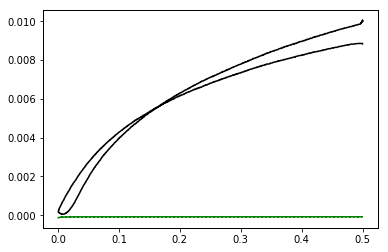

In [53]:
interact_manual (iplt,
         a=widgets.IntSlider(min=0,max=100e-12,step=1,value=10),
         b=widgets.IntSlider(min=0,max=100e-12,step=1,value=10),
        # c=widgets.IntSlider(min=0,max=100e10,step=1,value=10),
         )

## Preparing data to be fit to FUNC here

In [146]:
#Fit for the parameters a, b of the function func:
xdata = abs(b_field[900:1100])
#ydata = res/8 - 5131
ydata = (cond[900:1100]*8 - .0001947)/(e**2/h) # cond(b)-cond(0) in units of e^2/h
#ydata = (cond*8)/(e**2/h)

popt, pcov = curve_fit(func, xdata, ydata, bounds=([0, 0, 0], [1111,1111,1111]))
popt

array([  4.06037749e-08,   1.11100000e+03,   3.55734533e-09])

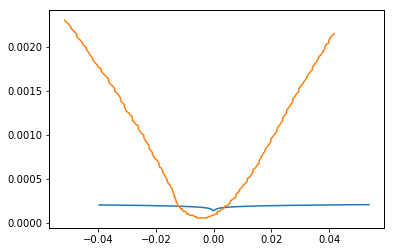

In [147]:
y = func(xdata, *popt)

mpl.plot(b_field[900:1100], y)
mpl.plot(b_field[900:1100]-0.012, ydata)
mpl.show()

In [126]:
ydata.shape
#mpl.plot(xdata, func(xdata, *popt), 'r-',
#    label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
#mpl.plot(xdata, func(xdata, *popt), 'r-',
#         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

(300,)

In [71]:
#cond*8.0*h/(k_F*e**2)

In [72]:
#hbar = 6.58e-16
#h = hbar/(2.0*np.pi)
#h = 6.626070040e-34
#hbar = 1.054571800e-34
#e = 1.60217662e-19
#np.sqrt(2*hbar/(e*0.020))

In [73]:
#y = func(xdata, *popt)

#mpl.plot(b_field, y)
#mpl.plot(b_field, ydata)
#mpl.show()


## Perform fitting below

In [90]:
#Constrain the optimization to the region of 0 <= a <= 10, 0 <= b <= 2:
popt, pcov = curve_fit(func, xdata, ydata, bounds=([0, 0, 0], [2e20, 1e+20, 0.0003]), max_nfev = 500)

popt
#mpl.plot(xdata, func(xdata, *popt), 'g--',
 #         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

array([  1.00000000e+20,   5.00000000e+19,   2.99719281e-04])

## Perform Plotting of fitted function

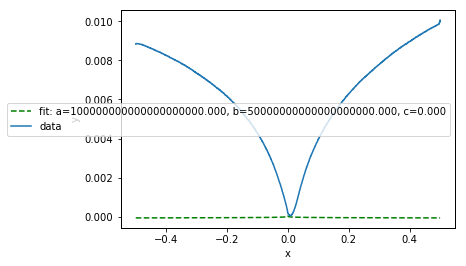

In [91]:
mpl.plot(b_field, func(xdata, *popt), 'g--',
          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

mpl.plot(b_field, ydata, label = 'data')

mpl.xlabel('x')
mpl.ylabel('y')
mpl.legend()
mpl.show()